In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Activation, Dropout, Flatten, BatchNormalization
from keras.optimizers import Adam
from keras.initializers import  RandomNormal
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/facial_expression/
!ls
fname = 'fer2013.csv'
fname
data = pd.read_csv(fname)

Mounted at /content/drive
/content/drive/MyDrive/facial_expression
checkpoint  facial_expression.tar.gz  fer2013.csv  history.csv	logs


In [ ]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


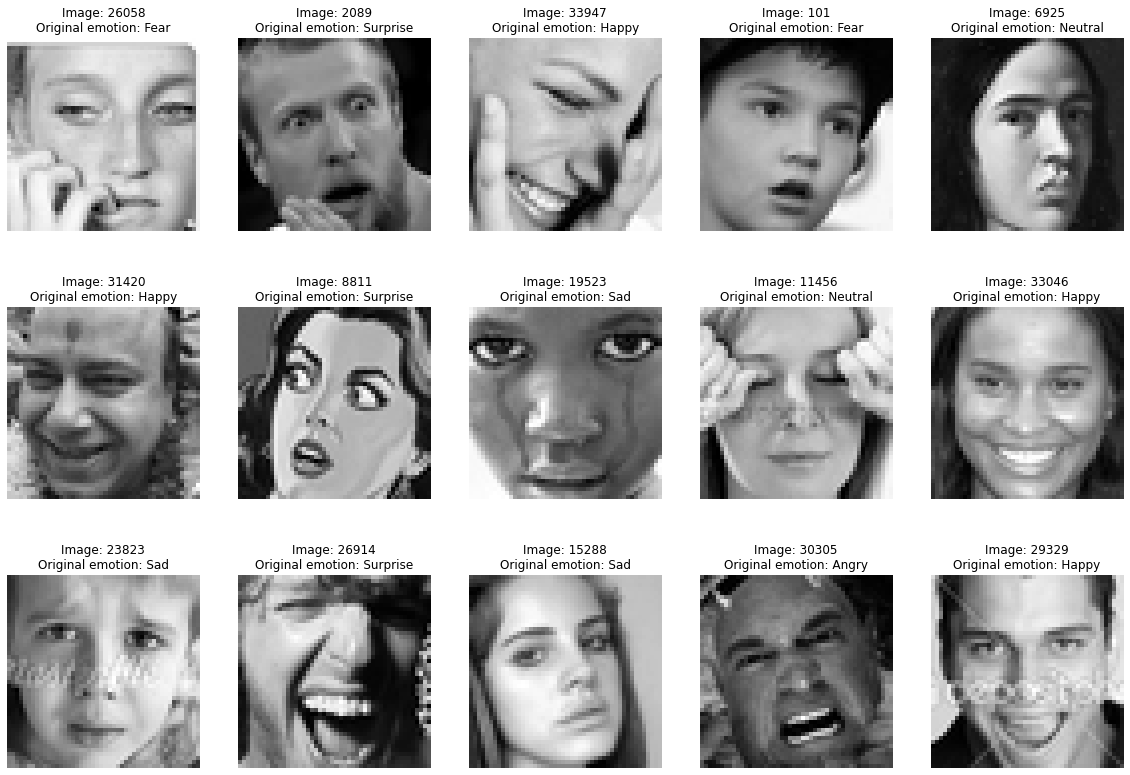

In [ ]:
emotions_names = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
data['emotion_name'] = data['emotion'].map(emotions_names)

pixels_values = data.pixels.str.split(" ").tolist()
pixels_values = pd.DataFrame(pixels_values, dtype=int)
images = pixels_values.values
images = images.astype(np.float)

test_idx_start = 32298
images_test = images[test_idx_start:]


# Function for displaying 15 random images
def show_random(imgs, emotion_nms_org = None, emotion_nms_pred = None, random = True, indices = None):
  """ 

    Function displaying 15 randomly chosen images. Arguments:
    
    imgs:  Source of images
    
    emotion_nms_org: Default "None", if specified, should be a Pandas Series object consisting of emotion names. As a result, emotion name will be displayed above every image.
    
    emotion_nms_pred: Default "None", if specified should be a Pandas Series object with predicted emotion names. As a result, emotion name will be displayed above image.
    
    random: Defult "True", indices will be randomly drawn from “discrete uniform” distribution starting at 0 up to max(len(imgs) otherwise randomly chosen from values passed into "indices" argument without replacement.
    
    indices: Default "None", if specified "random" should be set to "False" to draw random images from the variable passed into "indices" argument starting at min(len(indices)) up to max(len(indices)) and not using "discrete uniform" distribution. 
    
    """
    
  if (random == True):
    indices = np.random.randint(0, len(imgs), size = 15)
  else:
    indices = np.random.choice(list(indices), size = 15, replace = False)
  plt.figure(figsize=(20, 14)) 
  for index, number in enumerate(indices):
    plt.subplot(3,5, index + 1)
    if (isinstance(emotion_nms_org, type(None)) & isinstance(emotion_nms_pred, type(None))):
      plt.title('Image: ' + str(indices[index]))           
    elif (isinstance(emotion_nms_org, type(None)) & ~isinstance(emotion_nms_pred, type(None))):
      plt.title('Image: ' + str(indices[index]) + '\n' + 'Predicted emotion:' + emotion_nms_pred[indices[index]])
    elif (~isinstance(emotion_nms_org, type(None)) & isinstance(emotion_nms_pred, type(None))):
      plt.title('Image: ' + str(indices[index]) + '\n' + 'Original emotion: ' + emotion_nms_org[indices[index]])           
    else:
      plt.title('Image: ' + str(indices[index]) + '\n' + 'Original emotion: ' + emotion_nms_org[indices[index]] + 
                      '\n' + 'Predicted emotion:' + emotion_nms_pred[indices[index]])
    show_image = imgs[number].reshape(48,48)
    plt.axis('off')
    plt.imshow(show_image, cmap='gray')
        

show_random(images, emotion_nms_org= data['emotion_name'])


# Standarizing images
each_pixel_mean = images.mean(axis=0)
each_pixel_std = np.std(images, axis=0)
images = np.divide(np.subtract(images,each_pixel_mean), each_pixel_std)


image_pixels = images.shape[1]
image_width = image_height = np.ceil(np.sqrt(image_pixels)).astype(np.uint8)
labels_flat = data["emotion"].values.ravel()
labels_count = np.unique(labels_flat).shape[0]


# Function for creating zero/ones matrix indicating image label
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[[index_offset + labels_dense.ravel()]] = 1
    return labels_one_hot


labels = dense_to_one_hot(labels_flat, labels_count)
labels = labels.astype(np.uint8)

In [ ]:
images = images.reshape(images.shape[0], 48, 48, 1)
images = images.astype('float32')

# Splitting images and labels into training, validation and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, shuffle = False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle = False)

In [ ]:
# Constructing CNN structure
model = Sequential()

# 1st convolution layer
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', input_shape=(48,48,1), bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', input_shape=(48,48,1), bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.25))

# 3rd convolution layer
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.25))
          
# 5th convolution layer
model.add(Conv2D(128, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(128, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.25))

# 7th convolution layer
model.add(Conv2D(256, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(256, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.5))


model.add(Flatten())
# Fully connected layers
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(labels_count, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 23, 23, 64)        3

In [ ]:
# Compiling model
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])



# Specifying parameters for Data Augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=40,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,
    zoom_range = 0.05)  # zoom images in range [1 - zoom_range, 1+ zoom_range]

datagen.fit(X_train)
# Saving model each time it achieves lower loss on the validation set

import os
try:
  os.mkdir('checkpoint')
except:
    pass

file_name = 'best_model.h5'
filepath = os.path.join('checkpoint',file_name)
checkpointer = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
tensorboard = TensorBoard(log_dir='./logs')


history = model.fit_generator(datagen.flow(X_train, y_train,
                    batch_size=32),
                    epochs=200,
                    validation_data=(X_val, y_val),
                    steps_per_epoch=X_train.shape[0]/32,
                    callbacks=[checkpointer,tensorboard]
                             )


pd.DataFrame(history.history).to_csv("history.csv")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
908/908 [==============================] - 54s 22ms/step - loss: 2.7994 - accuracy: 0.2064 - val_loss: 1.9868 - val_accuracy: 0.2412

Epoch 00001: val_loss improved from inf to 1.98675, saving model to checkpoint/best_model.h5
Epoch 2/200
908/908 [==============================] - 17s 18ms/step - loss: 1.8226 - accuracy: 0.2428 - val_loss: 2.2847 - val_accuracy: 0.2396

Epoch 00002: val_loss did not improve from 1.98675
Epoch 3/200
908/908 [==============================] - 17s 18ms/step - loss: 1.7974 - accuracy: 0.2486 - val_loss: 2.3013 - val_accuracy: 0.2483

Epoch 00003: val_loss did not improve from 1.98675
Epoch 4/200
908/908 [==============================] - 17s 18ms/step - loss: 1.7927 - accuracy: 0.2559 - val_loss: 1.9177 - val_accuracy: 0.2749

Epoch 00004: val_loss improved from 1.98675 to 1.91769, saving model to checkpoint/best_model.h5
Epoch 5/200
908/908 [==============================] - 17s 18ms/step - loss: 1.7829 - accuracy: 0.2578 - val_loss: 1.9934 - 

In [ ]:
model2 = tf.keras.models.load_model(filepath)
scores = model2.evaluate(np.array(X_test), np.array(y_test), batch_size=1024)
print("Loss: " + str(scores[0]))
print("Accuracy: " + str(scores[1]))

4/4 [==============================] - 9s 1s/step - loss: 0.9170 - accuracy: 0.6534
Loss: 0.9170418977737427
Accuracy: 0.65338534116745


In [ ]:
history = pd.read_csv('history.csv', usecols = ['loss','accuracy','val_loss','val_accuracy'])

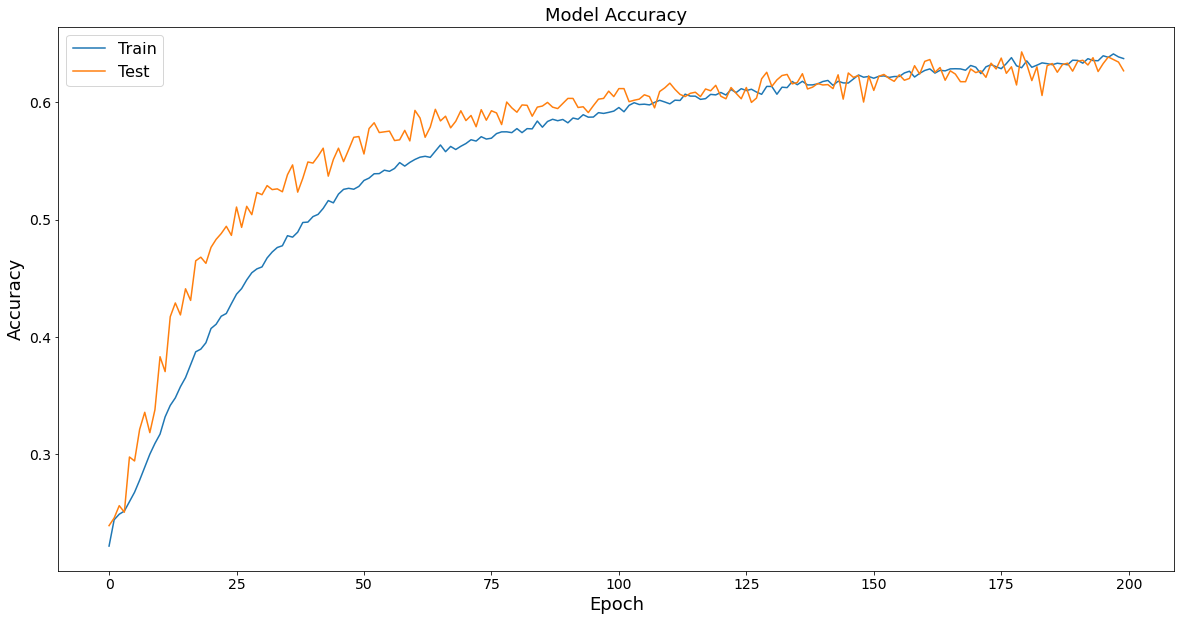

In [ ]:
def plot_accuracy(data, size = (20,10)):
    plt.figure(figsize=size) 
    plt.plot(data['accuracy'])
    plt.plot(data['val_accuracy'])
    plt.title('Model Accuracy', fontsize = 18)
    plt.ylabel('Accuracy', fontsize = 18)
    plt.xlabel('Epoch', fontsize = 18)
    plt.legend(['Train', 'Test'], loc='upper left', fontsize = 16)
    plt.tick_params(axis='both', labelsize=14)
    plt.show()
    
plot_accuracy(history)

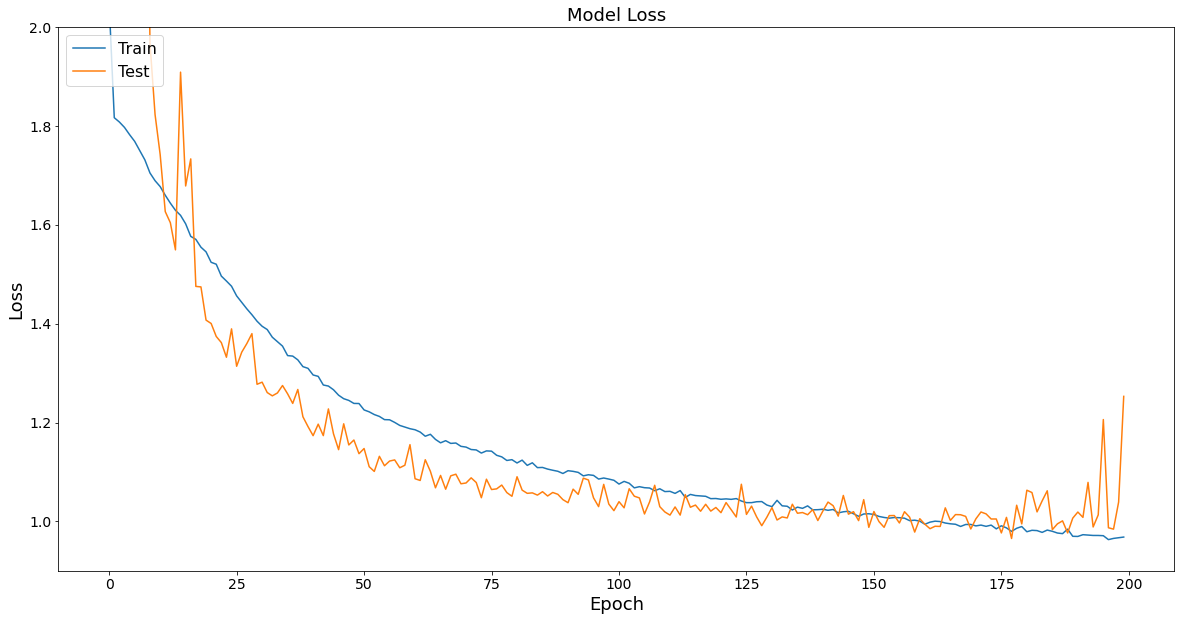

In [ ]:
def plot_loss(data, size = (20,10)):
    plt.figure(figsize=size) 
    plt.plot(data['loss'])
    plt.plot(data['val_loss'])
    plt.title('Model Loss', fontsize = 18)
    plt.ylabel('Loss', fontsize = 18)
    plt.xlabel('Epoch', fontsize = 18)
    plt.ylim(0.9,2)
    plt.legend(['Train', 'Test'], loc='upper left', fontsize = 16)
    plt.tick_params(axis='both', labelsize=14)
    plt.show()
    
plot_loss(history)


In [ ]:
def predict_classes(model, test_imgs, test_labels, emotions_dict,  batch_size  = 32):    

    # Predict class of image using trained model
    class_pred = model.predict(test_imgs, batch_size = batch_size)

    # Convert vector of zeros and ones to label
    labels_pred = np.argmax(class_pred,axis=1)
    true_labels = np.argmax(test_labels, axis=1)

    # Boolean array that indicates whether the predicted label is the true label
    correct = labels_pred == true_labels
    
    # Converting array of labels into emotion names
    pred_emotion_names = pd.Series(labels_pred).map(emotions_dict)
    
    results = {'Predicted_label': labels_pred, 'Predicted_emotion': pred_emotion_names, 'Is_correct' : correct}
    results = pd.DataFrame(results)
    return correct, results


def visualize_predictions(images_test, orglabel_names, predlabel_names, correct_arr, valid = True):
    
    if valid == True:
        correct = np.array(np.where(correct_arr == True))[0]
        # Plot 15 randomly selected and correctly predicted images
        show_random(images_test, emotion_nms_org = orglabel_names, emotion_nms_pred = predlabel_names, random = False, indices = correct)
    else:
        incorrect = np.array(np.where(correct_arr == False))[0]
        # Plot 15 randomly selected and wrongly predicted images
        show_random(images_test, emotion_nms_org = orglabel_names, emotion_nms_pred = predlabel_names, random = False, indices = incorrect)

In [ ]:
correct, results_df = predict_classes(model2, X_test, y_test, emotions_names, batch_size = 1024)
results_df['Original_label'] = data['emotion'][32298:].values
results_df['True_emotion'] = results_df['Original_label'].map(emotions_names)

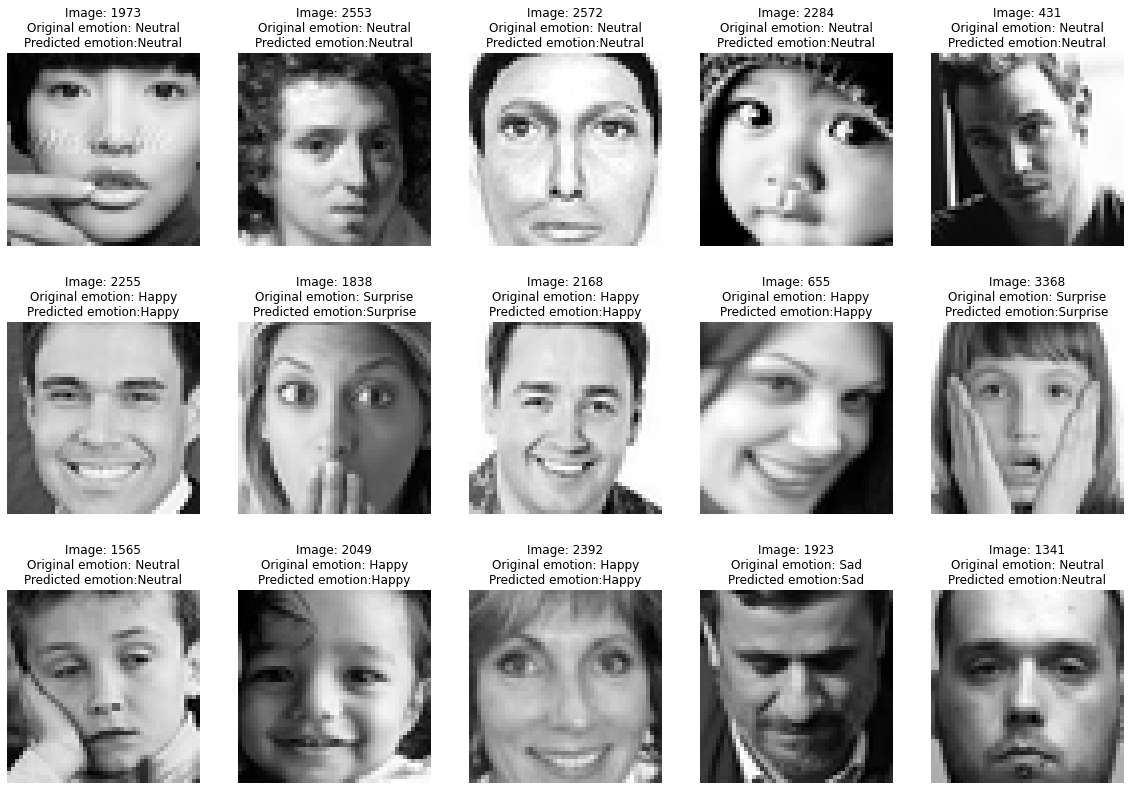

In [ ]:
visualize_predictions(images_test, results_df['True_emotion'], results_df['Predicted_emotion'], correct, valid = True)

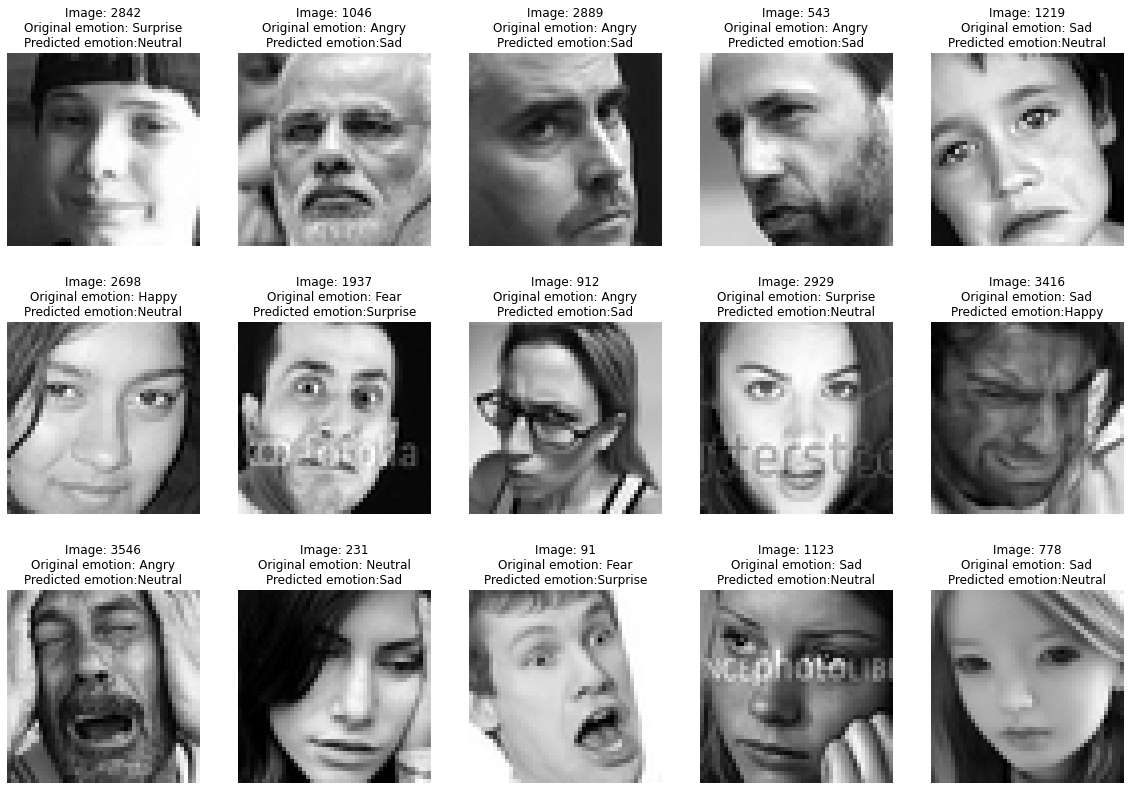

In [ ]:
visualize_predictions(images_test, results_df['True_emotion'], results_df['Predicted_emotion'], correct, valid = False)


In [ ]:
def create_confmat(true_labels, predicted_labels, columns, colour = 'Oranges', size = (20,14)):
    
    cm = confusion_matrix(true_labels, predicted_labels) 
    cm_df = pd.DataFrame(cm,
    index = [col for col in columns], 
    columns = [col for col in columns])
    plt.figure(figsize=(18,16))
    sns.heatmap(cm_df, annot = True, cmap = colour, fmt='g', linewidths=.2)
    plt.title('Confusion Matrix', fontsize = 20)
    plt.ylabel('True label', fontsize = 18)
    plt.xlabel('Predicted label', fontsize = 18)
    plt.tick_params(axis='both', labelsize=14)
    plt.show()

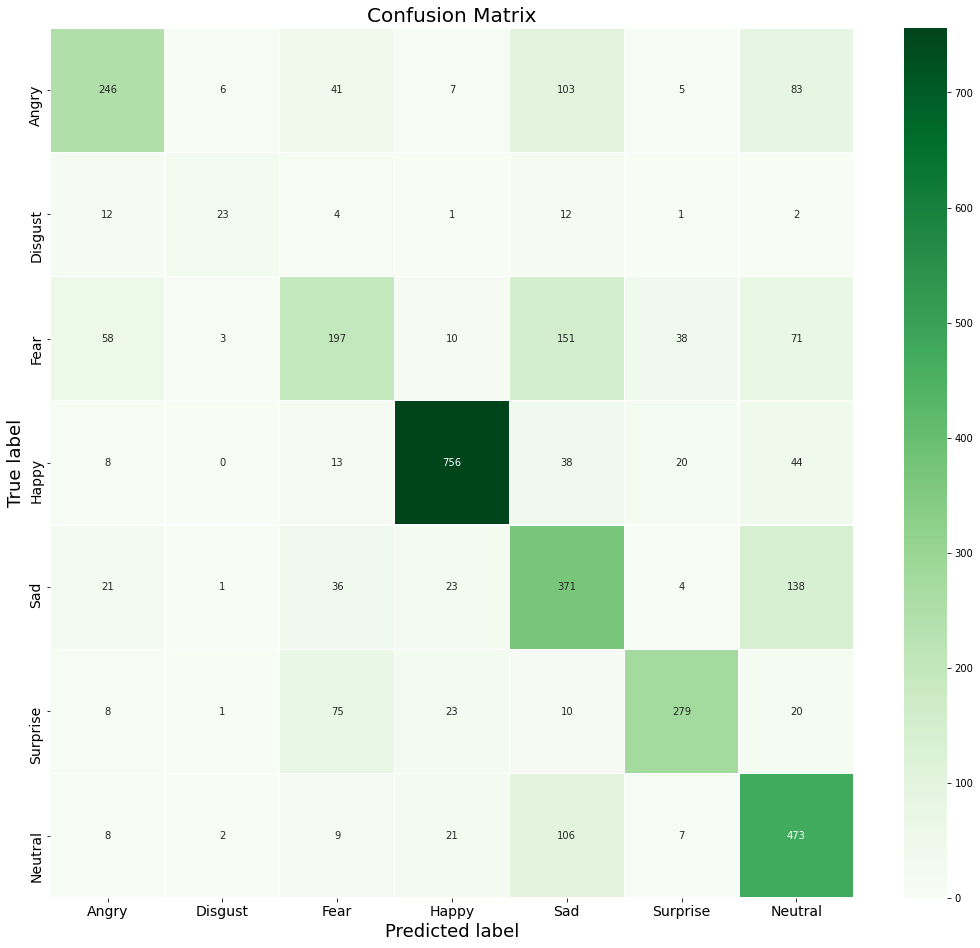

In [ ]:
# Displaying confusion matrix
create_confmat(results_df['Original_label'], results_df['Predicted_label'], ['Angry','Disgust','Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'], colour = 'Greens')